In [1]:
import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import mean_squared_error

# GPU initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model hyperparameters
latent_dim = 512
folder = f"model_at_{datetime.datetime.now()}"
model_weights_path = f'{folder}/model_weights_pytorch.pth'

# Custom callback equivalent for prediction evolution
class PredictionTracker:
    def __init__(self, encoder_model, decoder_model, initial_point, test_time, mean_psi, std_psi, actual_values, zonal_wind_idx=63):
        self.encoder_model = encoder_model
        self.decoder_model = decoder_model
        self.initial_point = initial_point.clone()  # Use clone() instead of copy() for PyTorch tensors
        self.test_time = test_time
        print(f"Debug: self.test_time = {self.test_time}")
        self.mean_psi = mean_psi
        self.std_psi = std_psi
        self.predictions_history = []
        self.actual_values = actual_values
        self.zonal_wind_idx = zonal_wind_idx
        
    def on_epoch_end(self, epoch, train_loss, val_loss):
        print(f"Epoch {epoch + 1}: Loss = {train_loss:.6f}, Validation Loss = {val_loss:.6f}")
        
        self.encoder_model.eval()
        self.decoder_model.eval()
        
        pred_mean = np.zeros((self.test_time, 75, 1))
        initial = self.initial_point.clone()
        
        with torch.no_grad():
            for k in tqdm(range(self.test_time), desc=f"Epoch {epoch + 1} Prediction Progress"):
                try:
                    # Get latent encoding
                    mu, log_var = self.encoder_model(initial)
                    z = self.reparameterize(mu, log_var)
                    
                    # Decode
                    pred_ens = self.decoder_model(z)
                    
                    pred_step = pred_ens.cpu().numpy().reshape(75, 1)
                    pred_mean[k, :, :] = pred_step
                    
                    # Denormalize prediction (PyTorch version of the TF code)
                    pred_denorm = (pred_step.squeeze() * self.std_psi.cpu().numpy() + 
                                   self.mean_psi.cpu().numpy()).reshape(1, 75, 1)
                    
                    # Normalize again for next input
                    initial = torch.tensor(
                        (pred_denorm - self.mean_psi.cpu().numpy().reshape(1, -1, 1)) / 
                        self.std_psi.cpu().numpy().reshape(1, -1, 1),
                        dtype=torch.float32
                    ).to(device)
                    
                except Exception as e:
                    print(f"Error during prediction at day {k}: {e}")
                    break
        
        # Denormalize final predictions
        pred_mean = pred_mean.squeeze() * self.std_psi.cpu().numpy().reshape(1, -1) + self.mean_psi.cpu().numpy().reshape(1, -1)
        pred_mean = pred_mean.reshape(self.test_time, 75, 1)
        self.predictions_history.append(pred_mean)
        
        # Save predictions and plot
        np.save(f'{folder}/predictions_epoch_{epoch+1}.npy', pred_mean)
        plt.figure(figsize=(15, 10))
        plt.plot(self.actual_values[:, self.zonal_wind_idx], 'b-', label='Actual', linewidth=2)
        plt.plot(pred_mean[:, self.zonal_wind_idx], 'r--', label=f'Predicted', linewidth=2)
        plt.title(f'Predictions vs Actual at Epoch {epoch+1}')
        plt.xlabel('Days')
        plt.ylabel('Zonal Wind Speed')
        plt.legend()
        plt.grid(True)
        plt.savefig(f'{folder}/prediction_epoch_{epoch+1}.png')
        plt.close()
        
        # Return models to training mode
        self.encoder_model.train()
        self.decoder_model.train()
    
    def reparameterize(self, mu, log_var):
        """
        Reparameterization trick to sample from N(mu, var) from N(0,1).
        """
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

def plot_prediction_evolution(predictions_history, actual_values, zonal_wind_idx=63):
    n_epochs = len(predictions_history)
    plt.figure(figsize=(15, 10))
    plt.plot(actual_values[:, zonal_wind_idx], 'k-', label='Actual', linewidth=2)
    
    for i, pred in enumerate(predictions_history):
        alpha = (i + 1) / n_epochs
        plt.plot(pred[:, zonal_wind_idx], alpha=alpha, 
                label=f'Epoch {i+1}', linestyle='--')
    
    plt.title(f'Evolution of Predictions at Index {zonal_wind_idx}')
    plt.xlabel('Days')
    plt.ylabel('Zonal Wind Speed')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{folder}/prediction_evolution.png')
    plt.show()

# Define PyTorch VAE model classes
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        
        # Convolutional layers with pooling (equivalent to TF model)
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1) 
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool1d(2)
        self.conv3 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool1d(2)
        
        # Calculate flattened size - original shape is (75, 1)
        # After 3 pooling layers: 75 -> 38 -> 19 -> 9 (slightly different from TF due to PyTorch pooling)
        self.flattened_size = 9 * 64
        
        # Latent space
        self.fc_mu = nn.Linear(self.flattened_size, latent_dim)
        self.fc_logvar = nn.Linear(self.flattened_size, latent_dim)
        
    def forward(self, x):
        # PyTorch expects [batch_size, channels, length] for Conv1d
        # So we need to permute from [batch_size, length, channels]
        x = x.permute(0, 2, 1)
        
        # Apply convolution and pooling layers with ReLU activations
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)
        x = torch.relu(self.conv2(x))
        x = self.pool2(x)
        x = torch.relu(self.conv3(x))
        x = self.pool3(x)
        
        # Flatten the tensor
        x = x.view(x.size(0), -1)
        
        # Get latent parameters
        mu = self.fc_mu(x)
        log_var = self.fc_logvar(x)
        
        return mu, log_var

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        
        # First reshape from latent space to match encoder's flattened shape
        self.latent_to_features = nn.Linear(latent_dim, 10 * 64)
        
        # Transpose convolutions (equivalent to upsampling + conv in TensorFlow)
        self.tconv1 = nn.ConvTranspose1d(64, 64, kernel_size=3, padding=1)
        self.upsample1 = nn.Upsample(scale_factor=2)
        self.tconv2 = nn.ConvTranspose1d(64, 64, kernel_size=3, padding=1)
        self.upsample2 = nn.Upsample(scale_factor=2) 
        self.tconv3 = nn.ConvTranspose1d(64, 64, kernel_size=3, padding=1)
        self.upsample3 = nn.Upsample(scale_factor=2)
        
        # Final output layer
        self.tconv_final = nn.ConvTranspose1d(64, 1, kernel_size=3, padding=1)
        
    def forward(self, z):
        # Reshape from latent dimension
        x = torch.relu(self.latent_to_features(z))
        x = x.view(-1, 64, 10)  # Reshape to [batch, channels, length]
        
        # Apply transpose convolutions with upsampling
        x = torch.relu(self.tconv1(x))
        x = self.upsample1(x)
        x = torch.relu(self.tconv2(x))
        x = self.upsample2(x)
        x = torch.relu(self.tconv3(x))
        x = self.upsample3(x)
        
        # Final layer and crop to match input shape (75, 1)
        x = self.tconv_final(x)
        x = x[:, :, :75]  # Crop to ensure correct output size
        
        # Convert back to [batch, length, channels] format
        x = x.permute(0, 2, 1)
        
        return x

class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)
        
    def reparameterize(self, mu, log_var):
        """
        Reparameterization trick to sample from N(mu, var) from N(0,1).
        """
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
        
    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        x_recon = self.decoder(z)
        return x_recon, mu, log_var
    
    def loss_function(self, recon_x, x, mu, log_var, beta=5):
        """
        Calculates VAE loss = reconstruction loss + KL divergence loss
        """
        # Reconstruction loss (MSE)
        recon_loss = torch.nn.functional.mse_loss(recon_x, x, reduction='mean')
        
        # KL divergence loss
        kl_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Total loss with beta weighting for KL term
        return recon_loss + beta * kl_loss, recon_loss, kl_loss

# Load and preprocess data (similar to TF code)
F = np.load('/home/fabio/work/HM_and_AI_models/VAE_Model/x_stoch.npy')
psi = F[3500:, 0, :]

# Normalize data
mean_psi = np.mean(psi, axis=0, keepdims=True)
std_psi = np.std(psi, axis=0, keepdims=True)
std_psi = np.maximum(std_psi, 1e-8) # Stop gradient explosion
psi = (psi - mean_psi) / std_psi

# Data preparation (same as TF code)
train_size = 220000
val_size = 50000
test_time = 30000
lead = 1

# Define indices for splitting
train_end = train_size
val_start = train_end
val_end = val_start + val_size

# Training data
psi_input_Tr = psi[:train_end, :].reshape(-1, 75, 1)
psi_label_Tr = psi[:train_end, :].reshape(-1, 75, 1)

# Validation data
psi_input_val = psi[val_start:val_end, :].reshape(-1, 75, 1)
psi_label_val = psi[val_start + lead:val_end + lead, :].reshape(-1, 75, 1)

# Test set size (10% of the dataset)
test_size = int(0.1 * psi.shape[0])

# Define test inputs and labels
psi_test_input = psi[val_end:val_end + test_size, :].reshape(-1, 75, 1)
psi_test_label = psi[val_end + lead:val_end + lead + test_size, :].reshape(-1, 75, 1)

# Define initial point for inference
initial_point = psi[val_end, :].reshape(1, 75, 1)

# Actual values corresponding to the test set for plotting
actual_values = (psi_test_label[:test_time, :, :].squeeze() * std_psi + mean_psi)

print(f"Shape of psi: {psi.shape}")
print(f"Train input shape: {psi_input_Tr.shape}")
print(f"Train label shape: {psi_label_Tr.shape}")
print(f"Validation input shape: {psi_input_val.shape}")
print(f"Validation label shape: {psi_label_val.shape}")
print(f"Test input shape: {psi_test_input.shape}")
print(f"Test label shape: {psi_test_label.shape}")
print(f"Initial point shape: {initial_point.shape}")

psi_input_Tr_tensor = torch.FloatTensor(psi_input_Tr).to(device)
psi_label_Tr_tensor = torch.FloatTensor(psi_label_Tr).to(device)
psi_input_val_tensor = torch.FloatTensor(psi_input_val).to(device)
psi_label_val_tensor = torch.FloatTensor(psi_label_val).to(device)
psi_test_input_tensor = torch.FloatTensor(psi_test_input).to(device)
psi_test_label_tensor = torch.FloatTensor(psi_test_label).to(device)
initial_point_tensor = torch.FloatTensor(initial_point).to(device)

# DataLoaders
train_dataset = TensorDataset(psi_input_Tr_tensor, psi_label_Tr_tensor)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

val_dataset = TensorDataset(psi_input_val_tensor, psi_label_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False)

mean_psi_tensor = torch.FloatTensor(mean_psi).to(device)
std_psi_tensor = torch.FloatTensor(std_psi).to(device)

# Initialize
vae = VAE(latent_dim).to(device)
optimizer = optim.Adam(vae.parameters())
torch.nn.utils.clip_grad_norm_(vae.parameters(), max_norm=1.0)

# Early stopping
best_val_loss = float('inf')
patience = 20
patience_counter = 0

# Prediction tracker
pred_tracker = PredictionTracker(
    vae.encoder, 
    vae.decoder, 
    initial_point_tensor, 
    test_time, 
    mean_psi_tensor, 
    std_psi_tensor, 
    actual_values, 
    zonal_wind_idx=63
)

# Training loop
def train_epoch(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    recon_loss_sum = 0
    kl_loss_sum = 0
    
    for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1} Training")):
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(data)
        loss, recon_loss, kl_loss = model.loss_function(recon_batch, target, mu, log_var)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        recon_loss_sum += recon_loss.item()
        kl_loss_sum += kl_loss.item()
    
    avg_loss = train_loss / len(train_loader)
    avg_recon_loss = recon_loss_sum / len(train_loader)
    avg_kl_loss = kl_loss_sum / len(train_loader)
    
    print(f"Epoch {epoch+1}: Train Loss = {avg_loss:.6f}, Recon Loss = {avg_recon_loss:.6f}, KL Loss = {avg_kl_loss:.6f}")
    return avg_loss

def validate(model, val_loader):
    model.eval()
    val_loss = 0
    
    with torch.no_grad():
        for data, target in tqdm(val_loader, desc="Validation"):
            recon_batch, mu, log_var = model(data)
            loss, _, _ = model.loss_function(recon_batch, target, mu, log_var)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss = {avg_val_loss:.6f}")
    return avg_val_loss

Using device: cuda
Shape of psi: (295900, 75)
Train input shape: (220000, 75, 1)
Train label shape: (220000, 75, 1)
Validation input shape: (50000, 75, 1)
Validation label shape: (50000, 75, 1)
Test input shape: (25900, 75, 1)
Test label shape: (25899, 75, 1)
Initial point shape: (1, 75, 1)
Debug: self.test_time = 30000


No pre-trained weights found. Training model...


Epoch 1 Training:   0%|          | 0/215 [00:00<?, ?it/s]

Epoch 1 Training: 100%|██████████| 215/215 [00:16<00:00, 13.19it/s]


Epoch 1: Train Loss = 0.166863, Recon Loss = 0.078426, KL Loss = 0.017687


Validation: 100%|██████████| 49/49 [00:01<00:00, 32.31it/s]


Validation Loss = 0.184758
Epoch 1: Loss = 0.166863, Validation Loss = 0.184758


Epoch 1 Prediction Progress: 100%|██████████| 30000/30000 [01:02<00:00, 482.99it/s]


Model weights saved to model_at_2025-03-23 16:50:28.471113 with point 1.
Model weights saved to model_at_2025-03-23 16:50:28.471113 for the best model.


Epoch 2 Training: 100%|██████████| 215/215 [00:14<00:00, 14.54it/s]


Epoch 2: Train Loss = 0.148886, Recon Loss = 0.067567, KL Loss = 0.016264


Validation: 100%|██████████| 49/49 [00:01<00:00, 35.54it/s]


Validation Loss = 0.166231
Epoch 2: Loss = 0.148886, Validation Loss = 0.166231


Epoch 2 Prediction Progress: 100%|██████████| 30000/30000 [00:53<00:00, 561.41it/s]


Model weights saved to model_at_2025-03-23 16:50:28.471113 with point 2.
Model weights saved to model_at_2025-03-23 16:50:28.471113 for the best model.


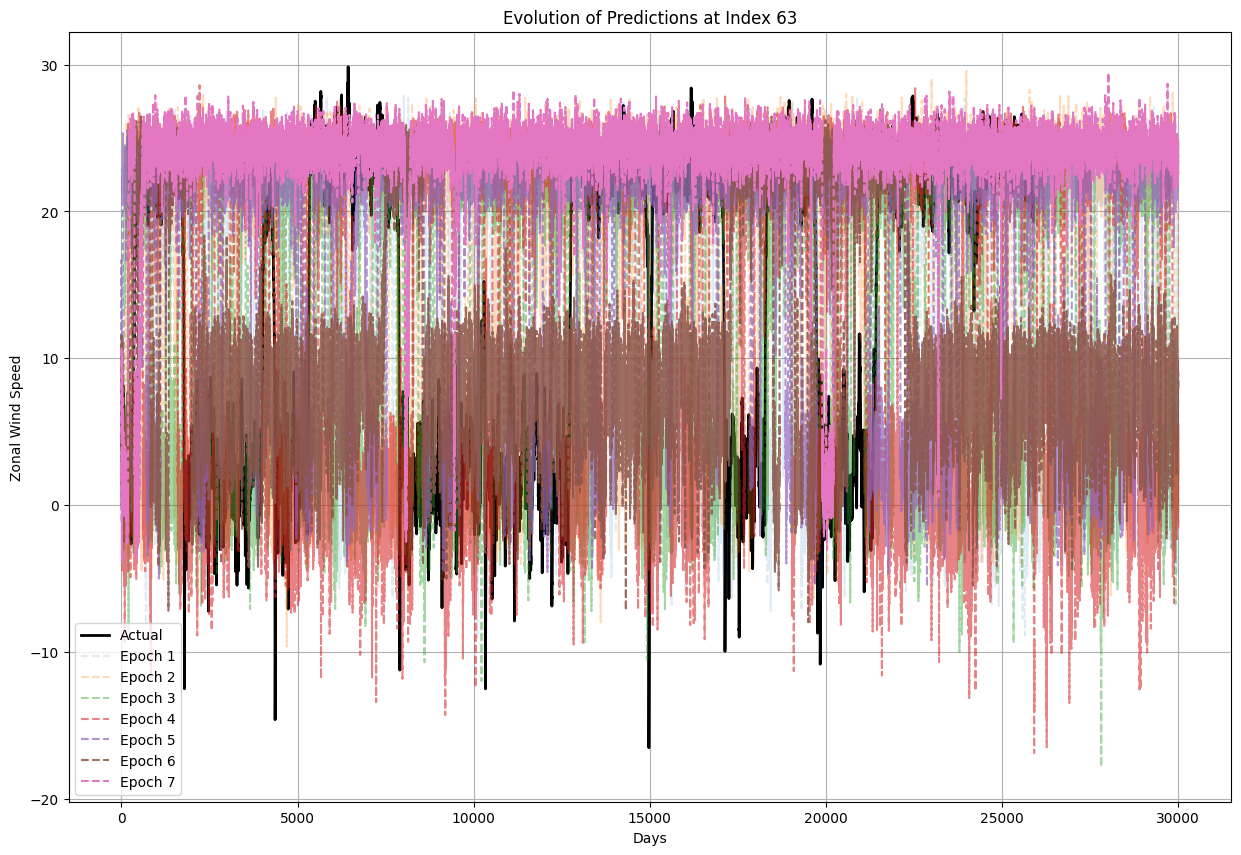


Starting inference...


Inference Progress: 100%|██████████| 30000/30000 [00:51<00:00, 582.37it/s]


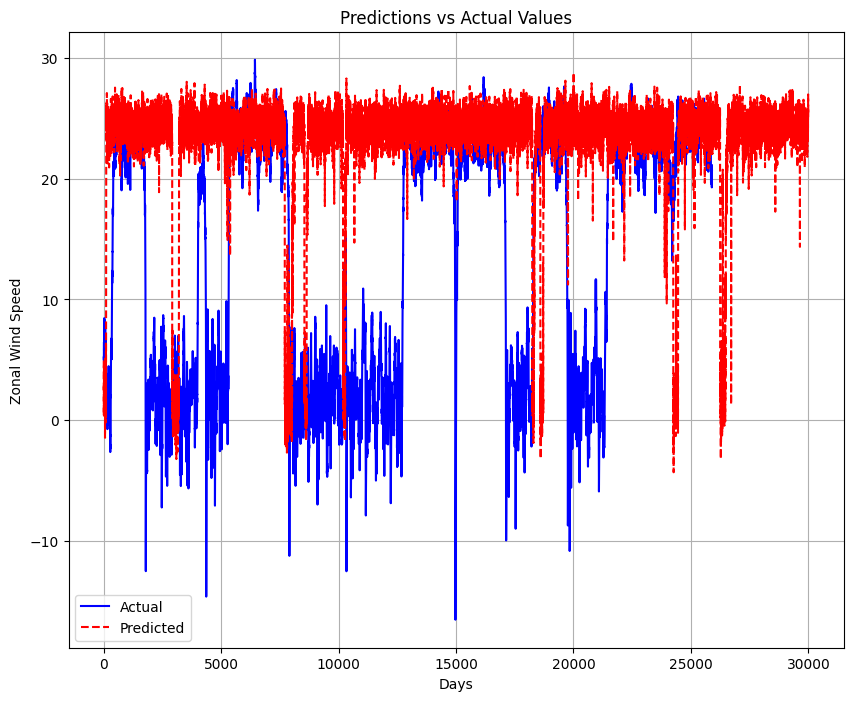

Could not load or plot training history: [Errno 2] No such file or directory: 'train_loss.npy'


In [7]:
# Training process
train_losses = []
val_losses = []
num_epochs = 2

# Check if pre-trained weights exist
if os.path.exists(model_weights_path):
    vae.load_state_dict(torch.load(model_weights_path, weights_only=True))
    print(f"Model weights loaded from {model_weights_path}.")
else:
    print(f"No pre-trained weights found. Training model...")
    
    os.makedirs(folder)

    for epoch in range(num_epochs):
        # Train for one epoch
        train_loss = train_epoch(vae, train_loader, optimizer, epoch)
        train_losses.append(train_loss)
        
        # Validate
        val_loss = validate(vae, val_loader)
        val_losses.append(val_loss)
        
        # Run prediction tracking
        pred_tracker.on_epoch_end(epoch, train_loss, val_loss)
        
        # Checkpoint per epoch

        torch.save(vae.state_dict(), f"{folder}/checkpoint_{epoch+1}")
        print(f"Model weights saved to {folder} with point {epoch+1}.")
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save best model
            torch.save(vae.state_dict(), f"{folder}/best_model")
            print(f"Model weights saved to {folder} for the best model.")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break
    
    # Save loss history for plotting
    np.save(f'{folder}train_loss.npy', np.array(train_losses))
    np.save(f'{folder}val_loss.npy', np.array(val_losses))

# Plot prediction evolution if predictions were tracked
if pred_tracker.predictions_history:
    plot_prediction_evolution(pred_tracker.predictions_history, actual_values, 63)

# Inference
print("\nStarting inference...")
pred_mean = np.zeros((test_time, 75, 1))

# Ensure model is in evaluation mode
vae.eval()

# Ensure correct shape of std_psi and mean_psi tensors
std_psi_tensor = std_psi_tensor.view(1, 75)
mean_psi_tensor = mean_psi_tensor.view(1, 75)

with torch.amp.autocast("cuda"):
    with torch.no_grad():
        current_input = initial_point_tensor.clone()
        
        # Inference loop with proper normalization
        for k in tqdm(range(test_time), desc="Inference Progress"):
            # Get latent encoding
            mu, log_var = vae.encoder(current_input)
            z = vae.reparameterize(mu, log_var)
            
            # Decode
            pred_step = vae.decoder(z)
            pred_mean[k, :, :] = pred_step.cpu().numpy()
            # Denormalize current prediction before using as next input
            pred_denorm = (pred_step.squeeze().cpu().numpy() * std_psi.squeeze() + mean_psi.squeeze()).reshape(1, 75, 1)
            
            # Normalize again for next input
            current_input = torch.tensor(
                (pred_denorm - mean_psi.reshape(1, -1, 1)) / std_psi.reshape(1, -1, 1),
                dtype=torch.float32
            ).to(device)

# Denormalize final predictions
pred_mean = pred_mean.squeeze() * std_psi.reshape(1, -1) + mean_psi.reshape(1, -1)
pred_mean = pred_mean.reshape(test_time, 75, 1)

# Calculate Mean Squared Error
# pred_flat = pred_mean.reshape(test_time, 75)
# actual_flat = actual_values
# mse_value = mean_squared_error(actual_flat, pred_flat)
# print(f"\nMean Squared Error: {mse_value}")

# Plot predictions vs actual for specific index
zonal_wind_idx = 63
plt.figure(figsize=(10, 8))
plt.plot(actual_values[:, zonal_wind_idx], label="Actual", color="blue")
plt.plot(pred_mean[:, zonal_wind_idx], label="Predicted", linestyle="dashed", color="red")
plt.title("Predictions vs Actual Values")
plt.xlabel("Days")
plt.ylabel("Zonal Wind Speed")
plt.legend()
plt.grid(True)
plt.savefig(f'{folder}/predictions_vs_actual.png')
plt.show()

# Save results
torch.save({
    'predictions': torch.tensor(pred_mean),
    'mean_psi': mean_psi_tensor.cpu(),
    'std_psi': std_psi_tensor.cpu(),
    'actual_values': torch.tensor(actual_values)
}, f'{folder}/model_results.pt')

# Plot training history if available
try:
    train_loss = np.load('train_loss.npy')
    val_loss = np.load('val_loss.npy')
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.title('Loss vs Epochs')
    plt.savefig(f'{folder}/loss_plot.png')
    plt.show()
except Exception as e:
    print(f"Could not load or plot training history: {e}")

In [ ]:
model_weights_path = "model_at_2025-03-18 01:21:06.900466/checkpoint_38"

test_time = 300000

if os.path.exists(model_weights_path):
    vae.load_state_dict(torch.load(model_weights_path, weights_only=True))
    print(f"Model weights loaded from {model_weights_path}.")

# Inference
print("\nStarting inference...")
pred_mean = np.zeros((test_time, 75, 1))

# Ensure model is in evaluation mode
vae.eval()
initial_point = psi[0, :].reshape(1, 75, 1)
initial_point_tensor = torch.FloatTensor(initial_point).to(device)
psi_test_label = psi[:, :].reshape(-1, 75, 1)
print(psi_test_label[:test_time, :, :].shape)
actual_values = (psi_test_label[:test_time, :, :].squeeze() * std_psi + mean_psi)
print(actual_values.shape)
# Ensure correct shape of std_psi and mean_psi tensors
std_psi_tensor = std_psi_tensor.view(1, 75)
mean_psi_tensor = mean_psi_tensor.view(1, 75)

with torch.amp.autocast("cuda"):
# No gradient tracking needed for inference
    with torch.no_grad():
        # Set initial point
        current_input = initial_point_tensor.clone()
        
        # Inference loop with proper normalization
        for k in tqdm(range(test_time), desc="Inference Progress"):
            # Get latent encoding
            mu, log_var = vae.encoder(current_input)
            z = vae.reparameterize(mu, log_var)
            
            # Decode
            pred_step = vae.decoder(z)
            
            if torch.isnan(pred_step).any():
                print(f"NaN detected at day {k}")
                print(f"mu values: {mu}")
                print(f"log_var values: {log_var}")
                print(f"z values: {z}")
                break

            pred_mean[k, :, :] = pred_step.cpu().numpy()
            # Denormalize current prediction before using as next input
            pred_denorm = (pred_step.squeeze().cpu().numpy() * std_psi.squeeze() + mean_psi.squeeze()).reshape(1, 75, 1)
            
            # Normalize again for next input
            current_input = torch.tensor(
                (pred_denorm - mean_psi.reshape(1, -1, 1)) / std_psi.reshape(1, -1, 1),
                dtype=torch.float32
            ).to(device)

# Denormalize final predictions
pred_mean = pred_mean.squeeze() * std_psi.reshape(1, -1) + mean_psi.reshape(1, -1)
pred_mean = pred_mean.reshape(test_time, 75, 1)

# Calculate Mean Squared Error
pred_flat = pred_mean.reshape(test_time, 75)
actual_flat = actual_values
# mse_value = mean_squared_error(actual_flat, pred_flat)
# print(f"\nMean Squared Error: {mse_value}")

# Plot predictions vs actual for specific index
zonal_wind_idx = 63
plt.figure(figsize=(14, 8))
plt.plot(actual_values[:, zonal_wind_idx], label="Actual", color="blue")
plt.plot(pred_mean[:, zonal_wind_idx], label="Predicted", linestyle="dashed", color="red")
plt.title("Predictions vs Actual Values")
plt.xlabel("Days")
plt.ylabel("Zonal Wind Speed")
plt.legend()
plt.grid(True)
plt.savefig('predictions_vs_actual.png')
plt.show()

# Save results
torch.save({
    'predictions': torch.tensor(pred_mean),
    'mean_psi': mean_psi_tensor.cpu(),
    'std_psi': std_psi_tensor.cpu(),
    'actual_values': torch.tensor(actual_values)
}, 'model_results.pt')

np.save(f'predictions_checkpoint_38.npy', pred_mean)


Starting inference...
(295900, 75, 1)
(295900, 75)


Inference Progress: 100%|██████████| 300000/300000 [10:12<00:00, 489.78it/s]


ValueError: Found input variables with inconsistent numbers of samples: [295900, 300000]

In [ ]:
import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import mean_squared_error

model_weights_path = "model_weights_pytorch2025-03-16 22:17:48.397214.pth"

test_time = 294000

if os.path.exists(model_weights_path):
    vae.load_state_dict(torch.load(model_weights_path, weights_only=True))
    print(f"Model weights loaded from {model_weights_path}.")

# Inference
print("\nStarting inference...")
pred_mean = np.zeros((test_time, 75, 1))

# Ensure model is in evaluation mode
vae.eval()
initial_point = psi[0, :].reshape(1, 75, 1)
initial_point_tensor = torch.FloatTensor(initial_point).to(device)
psi_test_label = psi[:, :].reshape(-1, 75, 1)
print(psi_test_label[:test_time, :, :].shape)
actual_values = (psi_test_label[:test_time, :, :].squeeze() * std_psi + mean_psi)
print(actual_values.shape)
# Ensure correct shape of std_psi and mean_psi tensors
std_psi_tensor = std_psi_tensor.view(1, 75)
mean_psi_tensor = mean_psi_tensor.view(1, 75)

with torch.amp.autocast("cuda"):
# No gradient tracking needed for inference
    with torch.no_grad():
        # Set initial point
        current_input = initial_point_tensor.clone()
        
        # Inference loop with proper normalization
        for k in tqdm(range(test_time), desc="Inference Progress"):
            # Get latent encoding
            mu, log_var = vae.encoder(current_input)
            z = vae.reparameterize(mu, log_var)
            
            # Decode
            pred_step = vae.decoder(z)
            
            if torch.isnan(pred_step).any():
                print(f"NaN detected at day {k}")
                print(f"mu values: {mu}")
                print(f"log_var values: {log_var}")
                print(f"z values: {z}")
                break

            pred_mean[k, :, :] = pred_step.cpu().numpy()
            # Denormalize current prediction before using as next input
            pred_denorm = (pred_step.squeeze().cpu().numpy() * std_psi.squeeze() + mean_psi.squeeze()).reshape(1, 75, 1)
            
            # Normalize again for next input
            current_input = torch.tensor(
                (pred_denorm - mean_psi.reshape(1, -1, 1)) / std_psi.reshape(1, -1, 1),
                dtype=torch.float32
            ).to(device)

# Denormalize final predictions
pred_mean = pred_mean.squeeze() * std_psi.reshape(1, -1) + mean_psi.reshape(1, -1)
pred_mean = pred_mean.reshape(test_time, 75, 1)

# Calculate Mean Squared Error
pred_flat = pred_mean.reshape(test_time, 75)
actual_flat = actual_values
mse_value = mean_squared_error(actual_flat, pred_flat)
print(f"\nMean Squared Error: {mse_value}")

# Plot predictions vs actual for specific index
zonal_wind_idx = 63
plt.figure(figsize=(14, 8))
plt.plot(actual_values[:, zonal_wind_idx], label="Actual", color="blue")
plt.plot(pred_mean[:, zonal_wind_idx], label="Predicted", linestyle="dashed", color="red")
plt.title("Predictions vs Actual Values")
plt.xlabel("Days")
plt.ylabel("Zonal Wind Speed")
plt.legend()
plt.grid(True)
plt.savefig('predictions_vs_actual.png')
plt.show()

# Save results
torch.save({
    'predictions': torch.tensor(pred_mean),
    'mean_psi': mean_psi_tensor.cpu(),
    'std_psi': std_psi_tensor.cpu(),
    'actual_values': torch.tensor(actual_values)
}, 'model_results.pt')